# Diffusion 2D Unconditional Example

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/aurelio-amerio/GenSBI-examples/blob/main/examples/NDE/diffusion_2d_unconditional.ipynb)

This notebook demonstrates how to train and sample from a diffusion (score-matching) model on a 2D toy dataset using JAX and Flax. We will cover data generation, model definition, training, sampling, and density estimation using the pipeline utility.

## 1. Environment Setup

In this section, we set up the notebook environment, import required libraries, and configure JAX for CPU or GPU usage.

In [1]:
# Load autoreload extension for development convenience
%load_ext autoreload
%autoreload 2

In [2]:
try: #check if we are using colab, if so install all the required software
    import google.colab
    colab=True
except:
    colab=False

In [3]:
if colab: # you may have to restart the runtime after installing the packages
    %pip install --quiet "gensbi[cuda12, examples] @ git+https://github.com/aurelio-amerio/GenSBI"
    !git clone --depth 1 https://github.com/aurelio-amerio/GenSBI-examples
    %cd GenSBI-examples/examples/NDE

In [4]:
# Set training and model restoration flags
overwrite_model = False
restore_model = True  # Use pretrained model if available
train_model = False  # Set to True to train from scratch

### Library Imports and JAX Backend Selection

In [5]:
# Import libraries and set JAX backend
import os
# os.environ['JAX_PLATFORMS']="cuda" # select cpu instead if no gpu is available
os.environ['JAX_PLATFORMS']="cpu"

from flax import nnx
import jax
import jax.numpy as jnp
import optax
import numpy as np

# Visualization libraries
import matplotlib.pyplot as plt
from matplotlib import cm

In [6]:
# Specify the checkpoint directory for saving/restoring models
import orbax.checkpoint as ocp
checkpoint_dir = f"{os.getcwd()}/checkpoints/diffusion_2d_example"

import os
os.makedirs(checkpoint_dir, exist_ok=True)

if overwrite_model:
    checkpoint_dir = ocp.test_utils.erase_and_create_empty(checkpoint_dir)

## 2. Data Generation

We generate a synthetic 2D dataset using JAX. This section defines the data generation functions and visualizes the data distribution.

In [7]:
# Define a function to generate 2D box data using JAX
import jax
import jax.numpy as jnp
from jax import random
from functools import partial
import grain

@partial(jax.jit, static_argnums=[1])  # type: ignore
def make_boxes_jax(key, batch_size: int = 200):
    """
    Generates a batch of 2D data points similar to the original PyTorch function
    using JAX.

    Args:
        key: A JAX PRNG key for random number generation.
        batch_size: The number of data points to generate.

    Returns:
        A JAX array of shape (batch_size, 2) with generated data,
        with dtype float32.
    """
    # Split the key for different random operations
    keys = jax.random.split(key, 3)
    x1 = jax.random.uniform(keys[0],batch_size) * 4 - 2
    x2_ = jax.random.uniform(keys[1],batch_size) - jax.random.randint(keys[2], batch_size, 0,2) * 2
    x2 = x2_ + (jnp.floor(x1) % 2)

    data = 1.0 * jnp.concatenate([x1[:, None], x2[:, None]], axis=1) / 0.45

    return data

/lhome/ific/a/aamerio/miniforge3/envs/gensbi/lib/python3.12/site-packages/google/protobuf/runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at grain/proto/execution_summary.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(


In [8]:
# # Infinite data generator for training batches
# @partial(jax.jit, static_argnums=[1])  # type: ignore
# def inf_train_gen(key, batch_size: int = 200):
#     x = make_boxes_jax(key, batch_size)

#     return x

batch_size = 256

data = make_boxes_jax(jax.random.PRNGKey(0), 500_000)

train_dataset_grain = (
    grain.MapDataset.source(np.array(data)[...,None])
    .shuffle(42)
    .repeat()
    .to_iter_dataset()
)

performance_config = grain.experimental.pick_performance_config(
            ds=train_dataset_grain,
            ram_budget_mb=1024 * 4,
            max_workers=None,
            max_buffer_size=None,
        )

train_dataset_batched = train_dataset_grain.batch(batch_size).mp_prefetch(
            performance_config.multiprocessing_options
        )

train_iter = iter(train_dataset_batched)

data_val = make_boxes_jax(jax.random.PRNGKey(1), 1000)

val_dataset_batched = (
    grain.MapDataset.source(np.array(data_val)[...,None])
    .shuffle(42)
    .repeat()
    .to_iter_dataset()
    .batch(512)
)

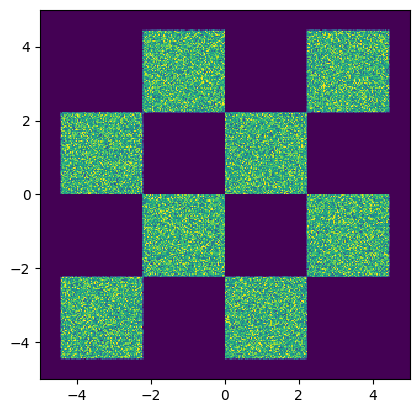

In [9]:
# Visualize the generated data distribution
samples = np.array(data)

H=plt.hist2d(samples[:,0], samples[:,1], 300, range=((-5,5), (-5,5)))
cmin = 0.0
cmax = jnp.quantile(jnp.array(H[0]), 0.99).item()
norm = cm.colors.Normalize(vmax=cmax, vmin=cmin)

_ = plt.hist2d(samples[:,0], samples[:,1], 300, range=((-5,5), (-5,5)), norm=norm, cmap="viridis")

# set equal ratio of axes
plt.gca().set_aspect('equal', adjustable='box')


plt.show()

## 3. Model and Loss Definition

We define the velocity field model (an MLP), the loss function, and the optimizer for training the score-matching model.

In [ ]:
# Import diffusion components and utilities
from gensbi.recipes import UnconditionalDiffusionPipeline

In [11]:
# Define the MLP velocity field model
class MLP(nnx.Module):
    def __init__(self, input_dim: int = 2, hidden_dim: int = 128, *, rngs: nnx.Rngs):

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim

        din = input_dim + 1

        self.linear1 = nnx.Linear(din, self.hidden_dim, rngs=rngs)
        self.linear2 = nnx.Linear(self.hidden_dim, self.hidden_dim, rngs=rngs)
        self.linear3 = nnx.Linear(self.hidden_dim, self.hidden_dim, rngs=rngs)
        self.linear4 = nnx.Linear(self.hidden_dim, self.hidden_dim, rngs=rngs)
        self.linear5 = nnx.Linear(self.hidden_dim, self.input_dim, rngs=rngs)

    def __call__(self, t: jax.Array, obs: jax.Array,  **kwargs):
        assert obs.ndim == 3, f"Input obs must have shape (batch_size, input_dim, 1), got {obs.shape}"

        # we need to massage the data a bit to make it compatible with the pipeline format
        t = jnp.atleast_1d(t)
        x = jnp.squeeze(obs, axis=-1)


        if t.ndim<2:
            t = t[..., None]

        if t.ndim==3:
            t = t[...,0]

        t = jnp.broadcast_to(t, (x.shape[0], t.shape[-1]))

        # now everything whould have the right dimension, we can proceed

        h = jnp.concatenate([x, t], axis=-1)

        x = self.linear1(h)
        x = jax.nn.gelu(x)

        x = self.linear2(x)
        x = jax.nn.gelu(x)

        x = self.linear3(x)
        x = jax.nn.gelu(x)

        x = self.linear4(x)
        x = jax.nn.gelu(x)

        x = self.linear5(x)

        return x[...,None]

In [12]:
# Initialize the velocity field model
hidden_dim = 512

# velocity field model init
model = MLP(input_dim=2, hidden_dim=hidden_dim, rngs=nnx.Rngs(0))

training_config = UnconditionalDiffusionPipeline.get_default_training_config()
training_config["checkpoint_dir"] = checkpoint_dir
training_config["nsteps"] = 30_000


pipeline = UnconditionalDiffusionPipeline(model,
    train_dataset_batched,
    val_dataset_batched,
    2,
    training_config=training_config)

In [13]:
# Restore the model from checkpoint if requested
if restore_model:
    pipeline.restore_model()

Restored model from checkpoint


In [14]:
model_params = nnx.state(pipeline.model, nnx.Param)
total_params  = sum(np.prod(x.shape) for x in jax.tree_util.tree_leaves(model_params))
print(f"Total model parameters: {total_params}")

Total model parameters: 791042


## 4. Training Loop

This section defines the training and validation steps, and runs the training loop if enabled. Early stopping and learning rate scheduling are used for efficient training.

In [15]:
if train_model:
    # Train the model
    pipeline.train(nnx.Rngs(0))

## 5. Sampling from the Model

In this section, we sample trajectories from the trained diffusion model and visualize the results at different time steps.

### sample the model

In [34]:
key = jax.random.PRNGKey(42)
# time steps: 20,
sol_ = pipeline.sample(key, nsamples=500_000, nsteps=19, return_intermediates=True)
jax.block_until_ready(sol_)
;

''

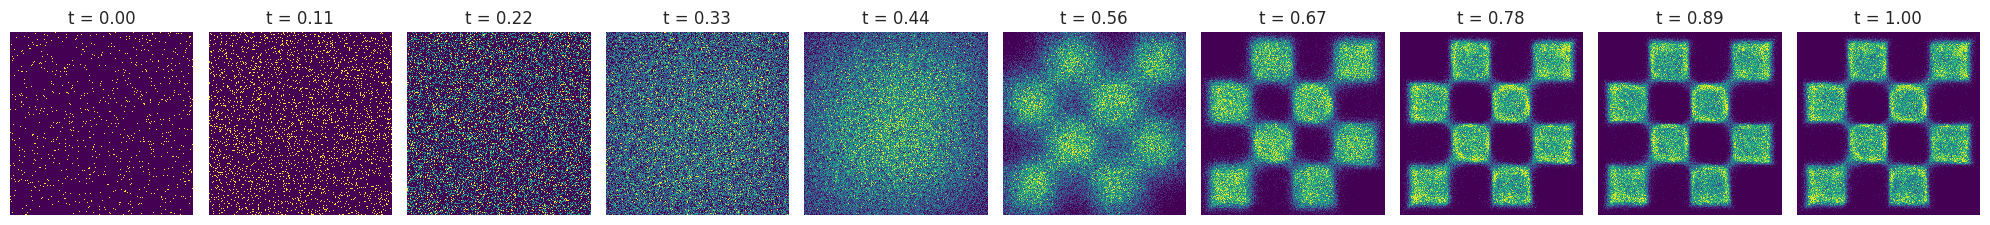

In [50]:
# Visualize the sampled trajectories at different time steps
sol = np.array(sol_[::2])  # convert to numpy array, take only one step every 2
T = np.linspace(0,1,10)  # convert to numpy array

fig, axs = plt.subplots(1, 10, figsize=(20,20))

for i in range(10):
    H = axs[i].hist2d(sol[i,:,0,0], sol[i,:,1,0], 300, range=((-5,5), (-5,5)))

    cmin = 0.0
    cmax = jnp.quantile(jnp.array(H[0]), 0.99).item()

    norm = cm.colors.Normalize(vmax=cmax, vmin=cmin)

    _ = axs[i].hist2d(sol[i,:,0,0], sol[i,:,1,0], 300, range=((-5,5), (-5,5)), norm=norm, cmap="viridis")

    axs[i].set_aspect('equal')
    axs[i].axis('off')
    axs[i].set_title('t = %.2f' % (T[i]))

plt.tight_layout()
plt.show()

## 6. Marginal and Trajectory Visualization

We visualize the marginal distributions and sample trajectories from the model.

In [36]:
# Import plotting utility for marginals
from gensbi.utils.plotting import plot_marginals

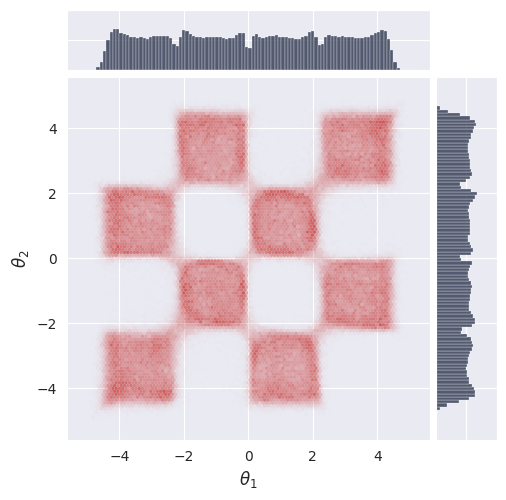

In [37]:
# Plot the marginal distribution of the final samples
plot_marginals(sol[-1,...,0], plot_levels=False, gridsize=100, backend="seaborn")
plt.show()

In [45]:
# Sample and visualize trajectories with finer time resolution
batch_size = 1000
# T = jnp.linspace(0,1,50)  # sample times
nsteps = 99

sol = pipeline.sample(key, nsamples=batch_size, nsteps=nsteps, return_intermediates=True)
jax.block_until_ready(sol)
;


''

In [46]:
# Import plotting utility for trajectories
from gensbi.utils.plotting import plot_trajectories

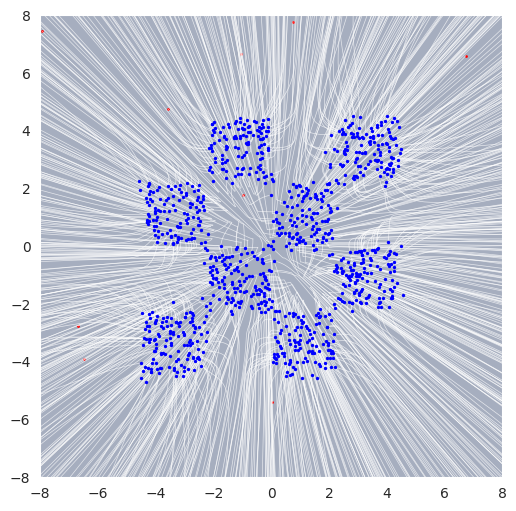

In [49]:
# Plot sampled trajectories
fig, ax = plot_trajectories(np.array(sol[...,0]))
plt.grid(False)
plt.xlim(-8,8)
plt.ylim(-8,8)
plt.show()